# Splitting Data

In [ ]:
from google.colab import drive
import os
import shutil
import pandas as pd
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import random
import logging
import warnings
import concurrent.futures
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# 🔹 Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 🔹 Define Directories
BASE_DIR = "/content/drive/MyDrive/TB_Chest_Xray"
DATASET_DIR = "/content/drive/MyDrive/TB_Dataset"
TRAINING_DIR = os.path.join(BASE_DIR, "training")
VAL_DIR = os.path.join(BASE_DIR, "validation")
TESTING_DIR = os.path.join(BASE_DIR, "testing")

# 🔹 Image Source Paths
SOURCE_PATH_NORM = os.path.join(DATASET_DIR, "Normal")
SOURCE_PATH_TB = os.path.join(DATASET_DIR, "Tuberculosis")

# Ensure directories exist
os.makedirs(BASE_DIR, exist_ok=True)

In [ ]:
# 🔹 Load Metadata
df_norm = pd.read_excel(os.path.join(DATASET_DIR, "Normal.metadata.xlsx"))
df_tb = pd.read_excel(os.path.join(DATASET_DIR, "Tuberculosis.metadata.xlsx"))

# Display basic metadata info
print("Normal Metadata Preview:")
print(df_norm.head(2))
print(f"Total Normal Samples: {df_norm.shape[0]}")

print("\nTB Metadata Preview:")
print(df_tb.head(2))
print(f"Total TB Samples: {df_tb.shape[0]}")

Normal Metadata Preview:
  FILE NAME FORMAT     SIZE                                                URL
0  Normal-1    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
1  Normal-2    PNG  512*512  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
Total Normal Samples: 3500

TB Metadata Preview:
        FILE NAME FORMAT     SIZE                      URL
0  Tuberculosis-1    PNG  512*512  http://tuberculosis.by/
1  Tuberculosis-2    PNG  512*512  http://tuberculosis.by/
Total TB Samples: 700


In [ ]:
# 🔹 Add Labels
df_norm["Tuberculosis"] = np.float32(0)
df_tb["Tuberculosis"] = np.float32(1)

# 🔹 Remove Unnecessary Columns
df_norm.drop(columns=["FORMAT", "SIZE", "URL"], errors="ignore", inplace=True)
df_tb.drop(columns=["FORMAT", "SIZE", "URL"], errors="ignore", inplace=True)

# 🔹 Combine and Shuffle Data
df = pd.concat([df_norm, df_tb]).sample(frac=1, random_state=42).reset_index(drop=True)
df.rename(columns={"FILE NAME": "Image"}, inplace=True)

print("Final Merged Dataset Shape:", df.shape)

Final Merged Dataset Shape: (4200, 2)


In [ ]:
# create whole images, train ,validation and test directories in output folder
def create_img_train_val_test_dirs(root_path):
    subsets = ['training', 'validation', 'testing']
    categories = ['Normal', 'Tuberculosis']

    for subset in subsets:
        for category in categories:
            os.makedirs(os.path.join(root_path, subset, category), exist_ok=True)

    os.makedirs(os.path.join(root_path, 'Images'), exist_ok=True)

create_img_train_val_test_dirs(BASE_DIR)

In [ ]:
# Map train validation test directories
# Update paths to use os.path.join with BASE_DIR
IMAGE_DIR = os.path.join(BASE_DIR, 'Images')
TRAINING_DIR = os.path.join(BASE_DIR, "training")
VAL_DIR = os.path.join(BASE_DIR, "validation")
TESTING_DIR = os.path.join(BASE_DIR, "testing")

TRAINING_NORM_DIR = os.path.join(TRAINING_DIR, "Normal/")
VAL_NORM_DIR = os.path.join(VAL_DIR, "Normal/")
TESTING_NORM_DIR = os.path.join(TESTING_DIR, "Normal/")
TRAINING_TB_DIR = os.path.join(TRAINING_DIR, "Tuberculosis/")
VAL_TB_DIR = os.path.join(VAL_DIR, "Tuberculosis/")
TESTING_TB_DIR = os.path.join(TESTING_DIR, "Tuberculosis/")

In [ ]:
def split_data(SOURCE, TRAINING, VAL, TESTING, SPLIT_SIZE_TRAIN=0.8, SPLIT_SIZE_VAL=0.1):
    zero_dir = [fn for fn in os.listdir(SOURCE) if os.path.getsize(os.path.join(SOURCE, fn)) == 0]
    for fn in zero_dir:
        print(fn, 'is zero length, so ignoring.')

    use_dir = [fn for fn in os.listdir(SOURCE) if fn not in zero_dir]
    random.seed(2)
    train_dt = random.sample(use_dir, int(SPLIT_SIZE_TRAIN * len(use_dir)))
    test_dt = [fn for fn in use_dir if fn not in train_dt]
    val_dt = random.sample(test_dt, int(SPLIT_SIZE_VAL * len(use_dir)))
    test_dt = [fn for fn in test_dt if fn not in val_dt]

    for fn in train_dt:
        shutil.copy(os.path.join(SOURCE, fn), TRAINING)
    for fn in val_dt:
        shutil.copy(os.path.join(SOURCE, fn), VAL)
    for fn in test_dt:
        shutil.copy(os.path.join(SOURCE, fn), TESTING)

split_data(SOURCE_PATH_NORM, TRAINING_NORM_DIR, VAL_NORM_DIR, TESTING_NORM_DIR)
split_data(SOURCE_PATH_TB, TRAINING_TB_DIR, VAL_TB_DIR, TESTING_TB_DIR)

In [ ]:
def images_copy(SOURCE_N, SOURCE_TB, IMAGE_DIR):
    zero_dir_n = [fn for fn in os.listdir(SOURCE_N) if os.path.getsize(os.path.join(SOURCE_N, fn)) == 0]
    zero_dir_tb = [fn for fn in os.listdir(SOURCE_TB) if os.path.getsize(os.path.join(SOURCE_TB, fn)) == 0]
    zero_dir = zero_dir_n + zero_dir_tb

    for fn in zero_dir:
        print(fn, 'is zero length, so ignoring.')

    use_dir_n = [fn for fn in os.listdir(SOURCE_N) if fn not in zero_dir]
    use_dir_tb = [fn for fn in os.listdir(SOURCE_TB) if fn not in zero_dir]
    random.seed(2)

    for fn in use_dir_n:
        shutil.copy(os.path.join(SOURCE_N, fn), IMAGE_DIR)
    for fn in use_dir_tb:
        shutil.copy(os.path.join(SOURCE_TB, fn), IMAGE_DIR)

images_copy(SOURCE_PATH_NORM, SOURCE_PATH_TB, IMAGE_DIR)
print(f"Total images copied to IMAGE_DIR: {len(os.listdir(IMAGE_DIR))}")

Total images copied to IMAGE_DIR: 4200


In [ ]:
def create_df(NORM_DIR, TB_DIR, df):
    # Get filenames from directories
    df_fn_n = os.listdir(NORM_DIR)
    df_fn_tb = os.listdir(TB_DIR)
    df_fn = df_fn_n + df_fn_tb

    # Ensure file names in df match actual file names
    df['Image'] = df['Image'].apply(lambda x: os.path.basename(x))  # Extract filenames from paths

    # Remove file extensions for matching
    df_ext = [fn.rsplit('.', 1)[0] for fn in df_fn]

    # Filter the dataframe to only include matching images
    df_res = df[df['Image'].apply(lambda x: x.rsplit('.', 1)[0]).isin(df_ext)]

    return df_res

# Create DataFrames for Training, Validation, and Testing
train_df = create_df(TRAINING_NORM_DIR, TRAINING_TB_DIR, df)
val_df = create_df(VAL_NORM_DIR, VAL_TB_DIR, df)
test_df = create_df(TESTING_NORM_DIR, TESTING_TB_DIR, df)

# Ensure file names have the correct extension
train_df['Image'] = train_df['Image'].apply(lambda x: x if x.endswith('.png') else x + '.png')
val_df['Image'] = val_df['Image'].apply(lambda x: x if x.endswith('.png') else x + '.png')
test_df['Image'] = test_df['Image'].apply(lambda x: x if x.endswith('.png') else x + '.png')

# Print total count
print("Total rows in train + val + test:", train_df.shape[0] + val_df.shape[0] + test_df.shape[0])

Total rows in train + val + test: 4200


In [ ]:
train_norm = glob.glob(TRAINING_NORM_DIR + '/*.png')
train_tb = glob.glob(TRAINING_TB_DIR + '/*.png')

print('Normal')
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i + 1)
    img = cv2.imread(train_norm[i])
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.show()

print('Tuberculosis')
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i + 1)
    img = cv2.imread(train_tb[i])
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
len(os.listdir(IMAGE_DIR))

4200

In [ ]:
# create df_train, df_val, df_test
def create_df(NORM_DIR, TB_DIR , df ):
    df_fn_n = os.listdir(NORM_DIR)
    df_fn_tb = os.listdir(TB_DIR)
    df_fn = df_fn_n + df_fn_tb
    df_ext = []
    for fn in df_fn:
        df_ext.append(fn[:-4])
    df_res = df[df['Image'].isin(df_ext)]

    return df_res

In [ ]:
train_df = create_df(TRAINING_NORM_DIR, TRAINING_TB_DIR ,df )
val_df = create_df(VAL_NORM_DIR, VAL_TB_DIR, df)
test_df = create_df(TESTING_NORM_DIR, TESTING_TB_DIR, df)

In [ ]:
# add .png as suffix in Filename column since our images name has .png as suffix also
train_df['Image'] = train_df['Image'] + '.png'
val_df['Image'] = val_df['Image'] + '.png'
test_df['Image'] = test_df['Image'] + '.png'

In [ ]:
# If we create dfs correctly, the sum of rows ahould be 4200
print(train_df.shape[0] + val_df.shape[0] + test_df.shape[0])

4200


# Preprocessing Data

In [ ]:
def get_train_generator(df, image_dir, x_col, y_col, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    # x_col (str): name of column in df that holds filenames.
    # y_col (list): name of column in df that holds labels.

    print("getting train generator...")
    # normalize each image using batch statistic
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        zoom_range = 0.1,
        rotation_range = 5,
        width_shift_range = 0.1,
        height_shift_range = 0.1)

    # flow from directory with specified batch size
    # and target image size
    train_generator = image_generator.flow_from_dataframe( dataframe=df,
                                                           directory=image_dir,
                                                           x_col=x_col,
                                                           y_col=y_col,
                                                           class_mode="raw",
                                                           batch_size=batch_size,
                                                           shuffle=shuffle,
                                                           seed=seed,
                                                           target_size=(target_w,target_h))



    return train_generator

In [ ]:
def get_test_and_valid_generator(val_df, test_df, train_df, image_dir, x_col, y_col, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):

    print("getting val and test generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe( dataframe=train_df,
                                                           directory=image_dir,
                                                           x_col= 'Image',
                                                           y_col= 'Tuberculosis',
                                                           class_mode="raw",
                                                           batch_size=sample_size,
                                                           shuffle=True,
                                                           seed=seed,
                                                           target_size=(target_w,target_h))

    # get data sample
    # Use __next__() instead of next()
    batch = raw_train_generator.__next__()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)

    # fit generator to sample from training data
    # This computes the internal data stats related to the data-dependent transformations, based on an array of sample data.
    image_generator.fit(data_sample)
    # if we want to calculate the mean and std on the entire training dataset
    # image_generator.fit(raw_train_generator)

    # get val and test generator
    val_generator = image_generator.flow_from_dataframe(
            dataframe=val_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    return val_generator, test_generator

In [ ]:
train_generator = get_train_generator(train_df, IMAGE_DIR, 'Image', 'Tuberculosis')
val_generator, test_generator= get_test_and_valid_generator(val_df, test_df, train_df, IMAGE_DIR, 'Image', 'Tuberculosis')

getting train generator...
Found 3360 validated image filenames.
getting val and test generators...
Found 3360 validated image filenames.
Found 420 validated image filenames.
Found 420 validated image filenames.


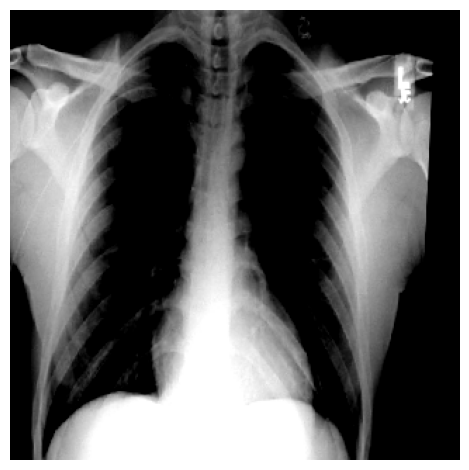

Image shape (320, 320, 3)


In [ ]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])
plt.axis("off")
plt.tight_layout()
plt.show()
print('Image shape',x[0].shape)

# Handling class imbalance

In [ ]:
train_tb = len(os.listdir(TRAINING_TB_DIR))
train_norm = len(os.listdir(TRAINING_NORM_DIR))
print('Percent of Tuberculosis/Normal : {} %'.format(100 * train_tb/train_norm))

Percent of Tuberculosis/Normal : 20.0 %


In [ ]:
#create positive frequency and negative frequency
freq_pos = round((train_tb/train_norm),2)
freq_neg = 1 - freq_pos

In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

In [ ]:
# create weight loss
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):

    def weighted_loss(y_true, y_pred):
        # initialize loss to zero
        loss = 0.0

        # for each class, add average weighted loss for that class
        loss += K.mean(-(pos_weights *y_true * K.log(y_pred + epsilon)
                             + neg_weights* (1 - y_true) * K.log( 1 - y_pred + epsilon)))
        return loss

    return weighted_loss

# Create model

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(320, 320, 3))

# Freeze base model layers (optional)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='AUC')]
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)
    ]
)

Epoch 1/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 124s 296ms/step - AUC: 0.9312 - accuracy: 0.9311 - loss: 0.2098 - val_AUC: 0.9606 - val_accuracy: 0.9262 - val_loss: 0.2032 - learning_rate: 5.0000e-05
Epoch 2/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 121s 288ms/step - AUC: 0.9373 - accuracy: 0.9203 - loss: 0.2161 - val_AUC: 0.9604 - val_accuracy: 0.9262 - val_loss: 0.2013 - learning_rate: 5.0000e-05
Epoch 3/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 122s 290ms/step - AUC: 0.9394 - accuracy: 0.9280 - loss: 0.2038 - val_AUC: 0.9624 - val_accuracy: 0.9262 - val_loss: 0.1981 - learning_rate: 5.0000e-05
Epoch 4/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 128s 305ms/step - AUC: 0.9476 - accuracy: 0.9296 - loss: 0.2013 - val_AUC: 0.9639 - val_accuracy: 0.9262 - val_loss: 0.1952 - learning_rate: 5.0000e-05
Epoch 5/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 133s 317ms/step - AUC: 0.9475 - accuracy: 0.9279 - loss: 0.2001 - val_AUC: 0.9661 - val_accuracy: 0.9262 - val_loss: 0.1982 - learning_rate: 5.0000e-05
Epoch 6/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
model.save("/content/drive/MyDrive/TB_Project/InceptionV3_tuberculosis.keras")

# Evaluate on test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TESTING_DIR,
    target_size=(320, 320),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_loss, test_acc, test_auc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test AUC: {test_auc:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 880ms/step
Test Accuracy: 89.76%
Precision: 1.0000
Recall: 0.3857
F1 Score: 0.5567
AUC Score: 0.9499


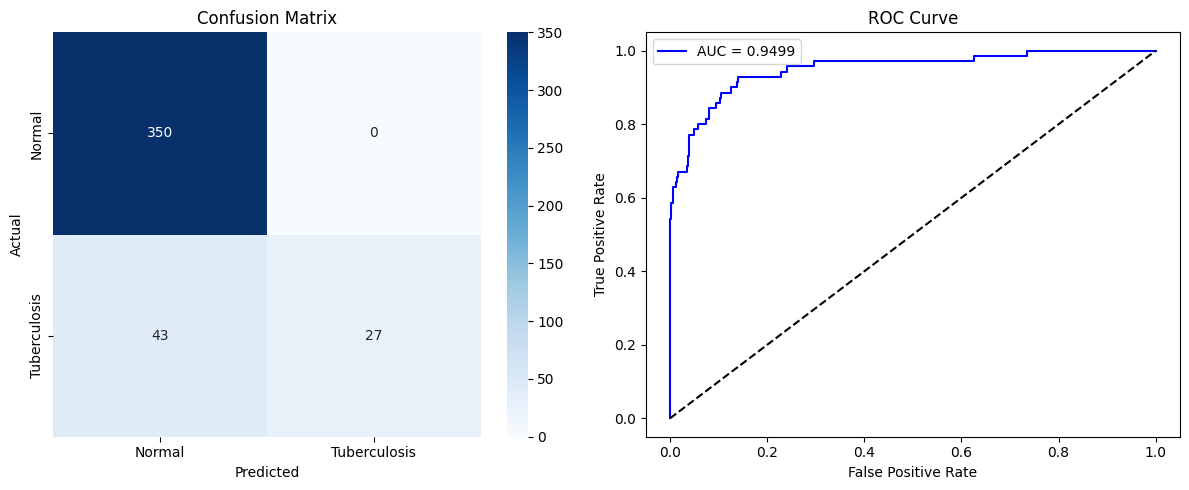

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

# Load the saved model
model = tf.keras.models.load_model("InceptionV3_tuberculosis.keras")

# Get true labels from test generator
y_true = test_generator.classes  # Actual labels (0 = Normal, 1 = Tuberculosis)

# Predict probabilities
y_pred_probs = model.predict(test_generator, steps=len(test_generator))

# Convert probabilities to binary predictions (Threshold = 0.5)
y_pred = (y_pred_probs >= 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_probs)

# Print metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

# ---------------- PLOTTING ---------------- #
plt.figure(figsize=(12, 5))

# 1️⃣ Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Tuberculosis"], yticklabels=["Normal", "Tuberculosis"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# 2️⃣ ROC Curve
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color="blue")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.tight_layout()
plt.show()

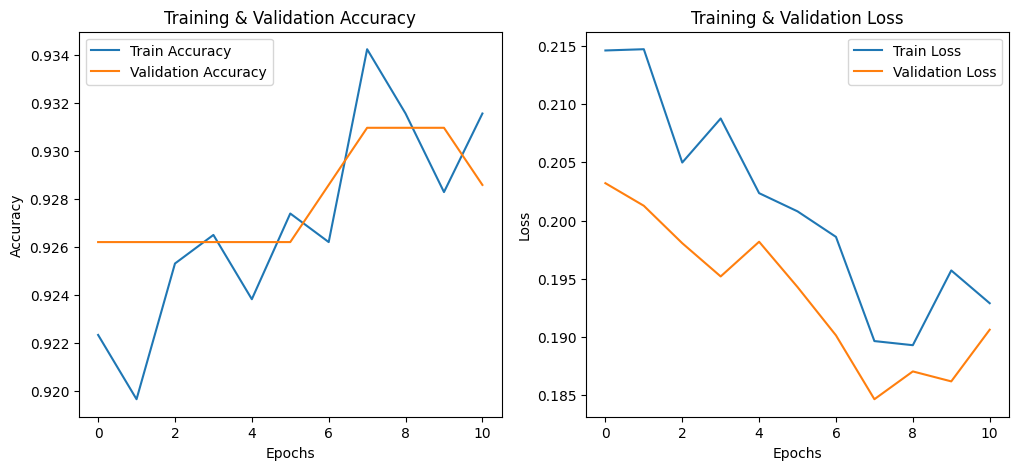

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.show()

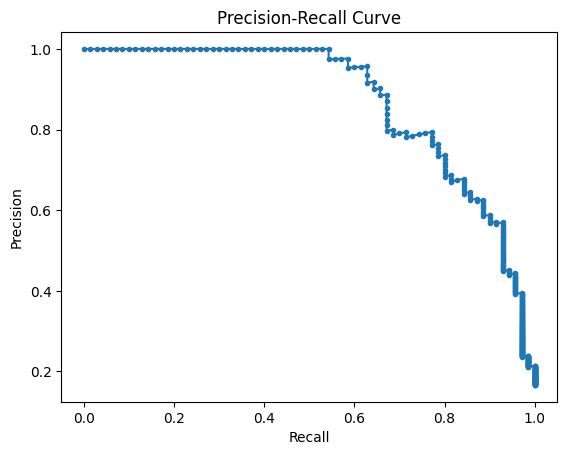

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

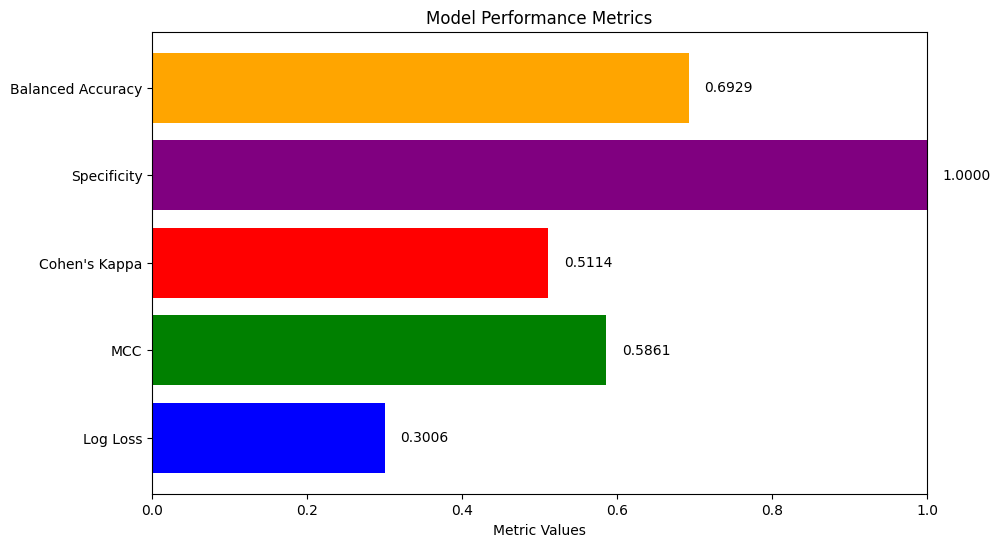

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, matthews_corrcoef, cohen_kappa_score, confusion_matrix, balanced_accuracy_score

# Assume y_true (true labels) and y_pred_probs (predicted probabilities) are available
# Convert probabilities to binary predictions using 0.5 threshold
y_pred = np.where(y_pred_probs >= 0.5, 1, 0)

# Compute metrics
log_loss_value = log_loss(y_true, y_pred_probs)
mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

# Compute Specificity (True Negative Rate)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp)

# Compute Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_true, y_pred)

# Plot metrics
metrics_names = ["Log Loss", "MCC", "Cohen's Kappa", "Specificity", "Balanced Accuracy"]
metrics_values = [log_loss_value, mcc, kappa, specificity, balanced_acc]

plt.figure(figsize=(10, 6))
plt.barh(metrics_names, metrics_values, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel("Metric Values")
plt.title("Model Performance Metrics")
plt.xlim(0, 1)  # Set x-axis limit for better visualization (except MCC, which ranges from -1 to 1)
for index, value in enumerate(metrics_values):
    plt.text(value + 0.02, index, f"{value:.4f}", va='center')  # Display values on bars
plt.show()